In [22]:
%load_ext autoreload
%autoreload 2

%pylab inline
from imagery_psychophysics.src.inference_machinery import *
from imagery_psychophysics.src.counting_machinery import *
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### Counting number of possible colorings given all possible color counts. Nailed it!

In [9]:
n_colors = 4
target_sequence = [1,2,3,4,5,6]
experimental_observations = {(1,2,3):1, (2,3):2, (3,4,5):3, (4,6):4, (6,):6}
exp_obs = format_experimental_obsevations(experimental_observations)
seq = create_sequence_of_nbd_obs(target_sequence,exp_obs)

In [10]:
for s in seq:
    print '---'
    print s.target
    print s.nbd_windows.string
    print s.not_summed.reduce2window().tup
    print s.resp_dict

---
1
1,2,3
(2, 3)
{(1, 2, 3): 1}
---
2
2,3
(3,)
{(2, 3): 2}
---
3
3,4,5
(4, 5)
{(3, 4, 5): 3}
---
4
4,5,6
(5, 6)
{(4, 6): 4}
---
5
5,6
(6,)
{}
---
6
6
()
{(6,): 6}


In [11]:
##create a sequence of samples/counters
sample_seq = []
counter_seq = []
for ii,s in enumerate(seq):
    print ii
    sample_seq.append(enumerate_nbd_color_counts(n_colors,s.nbd_windows))
    counter_seq.append(consistent_map_counter(s.target,s.nbd_windows.powerset(nonempty=True)))

0
counts so far: 0
took 0.002293 seconds
took 0.226387 seconds
---
should be: 3375. Is: 3375
reduced to: 239
reduction is: 92.918519 percent
1
counts so far: 0
took 0.001013 seconds
took 0.017777 seconds
---
should be: 225. Is: 225
reduced to: 26
reduction is: 88.444444 percent
2
counts so far: 0
took 0.001846 seconds
took 0.238566 seconds
---
should be: 3375. Is: 3375
reduced to: 239
reduction is: 92.918519 percent
3
counts so far: 0
took 0.001935 seconds
took 0.232562 seconds
---
should be: 3375. Is: 3375
reduced to: 239
reduction is: 92.918519 percent
4
counts so far: 0
took 0.001077 seconds
took 0.016178 seconds
---
should be: 225. Is: 225
reduced to: 26
reduction is: 88.444444 percent
5
counts so far: 0
took 0.000543 seconds
took 0.002511 seconds
---
should be: 15. Is: 15
reduced to: 4
reduction is: 73.333333 percent


In [12]:
coloring_messenger(n_colors,seq,sample_seq,counter_seq)
print 'should be: %d' %((2**n_colors-1)**len(target_sequence))

===============target window: 1
current observations: {(1, 2, 3): 1}
window: 1, assuming constant or no message
finished counting in 0.149463 seconds
elapsed time, iteration 1: 0.186630
===============target window: 2
current observations: {(2, 3): 2}
finished counting in 0.013731 seconds
elapsed time, iteration 2: 0.019654
===============target window: 3
current observations: {(3, 4, 5): 3}
finished counting in 0.155023 seconds
elapsed time, iteration 3: 0.162138
===============target window: 4
current observations: {(4, 6): 4}
finished counting in 0.158854 seconds
elapsed time, iteration 4: 0.165068
===============target window: 5
current observations: {}
finished counting in 0.013484 seconds
elapsed time, iteration 5: 0.017607
===============target window: 6
current observations: {(6,): 6}
finished counting in 0.003797 seconds
window 6, no groupby. summing
elapsed time, iteration 6: 0.007593
*******final message is: 11390625.000000
should be: 11390625


### Counting mean number of consistent colorings given a subsample of possible color counts. 
In this case, we don't enumerate over all the possible color counts for a given number of windows/number of colors. Instead we sample some number of color counts for the nbd of each window. We iterate across nbds, counting the number of consistent colorings for each sample. We first consider nbds of up to size 8, where each nbd overlaps by all but 1 window. We then consider non-overlapping nbds, but vary their size. Basically the result is that we can reduce the number of consistent mappings either by overlapping nbds or by large nbds -- it is ultimately a matter of tree-width. I think, however, that if we are considering number of consistent *maps*, then geometry comes into play, and it is not just tree-width but the spatial extent of the windows that matters.

In [13]:
def make_one_nbd_coloring(n_colors, window_nbd):
    window_colorings = []
    for _ in window_nbd.tup:
        coloring = np.zeros(n_colors,dtype=int)
        n = np.random.randint(1,high=n_colors)
        npos = np.random.randint(0,high=n_colors,size=n)
        coloring[npos] = 1
        window_colorings.append(bitarray(list(coloring)))
    return window_colorings

In [14]:
def make_one_nbd_color_count(n_colors, window_nbd):
    window_colorings = make_one_nbd_coloring(n_colors, window_nbd)
    nbd,unions = nbd_color_counts(window_nbd,window_colorings)
    df = pd.DataFrame(columns=nbd.strings, index = [0])
    df.iloc[0,:] = unions
    return df
#     return nbd,unions


In [15]:
def nbds_generator_1(number_of_windows,nbd_size):
    list_of_windows = np.arange(0,number_of_windows)
    nbds = []
    for w in list_of_windows:
        nbds += [tuple(np.sort(list_of_windows[np.argsort(np.abs(w-list_of_windows))[0:nbd_size]]))]
    
    return nbds

In [16]:
def nbds_generator_2(number_of_windows,nbd_size,stride):
    nbds = []
    for w in range(0,number_of_windows,stride):
        nbds += [tuple(range(w,w+nbd_size))]
    
    return [n for n in nbds if all([j<number_of_windows for j in n])]

In [17]:
nbds = uniquify(nbds_generator_2(64,8,4))
experimental_observations = dict((n,1) for n in nbds)
exp_obs = format_experimental_obsevations(experimental_observations)
##construct the counting sequences
seq = create_sequence_of_nbd_obs(range(64),exp_obs)

In [18]:
for s in seq:
    print s.nbd_windows.string

0,1,2,3,4,5,6,7
1,2,3,4,5,6,7
2,3,4,5,6,7
3,4,5,6,7
4,5,6,7,8,9,10,11
5,6,7,8,9,10,11
6,7,8,9,10,11
7,8,9,10,11
8,9,10,11,12,13,14,15
9,10,11,12,13,14,15
10,11,12,13,14,15
11,12,13,14,15
12,13,14,15,16,17,18,19
13,14,15,16,17,18,19
14,15,16,17,18,19
15,16,17,18,19
16,17,18,19,20,21,22,23
17,18,19,20,21,22,23
18,19,20,21,22,23
19,20,21,22,23
20,21,22,23,24,25,26,27
21,22,23,24,25,26,27
22,23,24,25,26,27
23,24,25,26,27
24,25,26,27,28,29,30,31
25,26,27,28,29,30,31
26,27,28,29,30,31
27,28,29,30,31
28,29,30,31,32,33,34,35
29,30,31,32,33,34,35
30,31,32,33,34,35
31,32,33,34,35
32,33,34,35,36,37,38,39
33,34,35,36,37,38,39
34,35,36,37,38,39
35,36,37,38,39
36,37,38,39,40,41,42,43
37,38,39,40,41,42,43
38,39,40,41,42,43
39,40,41,42,43
40,41,42,43,44,45,46,47
41,42,43,44,45,46,47
42,43,44,45,46,47
43,44,45,46,47
44,45,46,47,48,49,50,51
45,46,47,48,49,50,51
46,47,48,49,50,51
47,48,49,50,51
48,49,50,51,52,53,54,55
49,50,51,52,53,54,55
50,51,52,53,54,55
51,52,53,54,55
52,53,54,55,56,57,58,59
53,54,55,

In [19]:
##this is important chunk of code.
def make_color_count_sample_sequence(sequence_of_nbd_obs, n_colors, n_samples):

    all_windows = window([n.target for n in sequence_of_nbd_obs])
    n_windows = len(all_windows.tup)
    all_coloring_samples = pd.DataFrame(data = [make_one_nbd_coloring(n_colors,all_windows) for _ in range(n_samples)],
                                        columns = all_windows.string.split(','))
    sample_sequence = []

    for s in sequence_of_nbd_obs:
        win_names =  s.nbd_windows.string.split(',')
        def row_func(row):
            _,unions = nbd_color_counts(s.nbd_windows,row)
            return pd.Series(unions)
        col_names = s.nbd_windows.powerset(nonempty=True).strings
        rename = dict(zip(range(len(col_names)),col_names))
        ss = all_coloring_samples[win_names].apply(row_func,axis=1).rename(columns=rename)

        sample_sequence.append(ss)
    return sample_sequence

        

In [20]:
##construct a sequence of window observations
n_colors = 6
n_windows = 64
n_samples = 500
target_sequence = range(n_windows)
nbd_stride = 1
nc_mn = []
nc_std = []
nc_min = []
nc_max = []
for nbd_size in range(1,11):
    ##construct the nbd
    nbds = uniquify(nbds_generator_2(n_windows,nbd_size,nbd_stride))
    print '----number of windows: %d' %(len(nbds))
    experimental_observations = dict((n,1) for n in nbds)
    exp_obs = format_experimental_obsevations(experimental_observations)
    ##construct the counting sequences
    seq = create_sequence_of_nbd_obs(target_sequence,exp_obs)
    sample_seq = make_color_count_sample_sequence(seq, n_colors, n_samples)
    counter_seq = []
    for s in seq:
        counter_seq.append(consistent_map_counter(s.target,s.nbd_windows.powerset(nonempty=True)))
    mess,mess_seq = indie_coloring_messenger(n_colors,seq,sample_seq,counter_seq,doprint=False)
    nc_mn.append(mess.mean())
    nc_std.append(mess.std())
    nc_min.append(mess.min())
    nc_max.append(mess.max())

----number of windows: 64
===============target window: 0
===============target window: 1
===============target window: 2
===============target window: 3
===============target window: 4
===============target window: 5
===============target window: 6
===============target window: 7
===============target window: 8
===============target window: 9
===============target window: 10
===============target window: 11
===============target window: 12
===============target window: 13
===============target window: 14
===============target window: 15
===============target window: 16
===============target window: 17
===============target window: 18
===============target window: 19
===============target window: 20
===============target window: 21
===============target window: 22
===============target window: 23
===============target window: 24
===============target window: 25
===============target window: 26
===============target window: 27
===============target window: 28
===============target windo

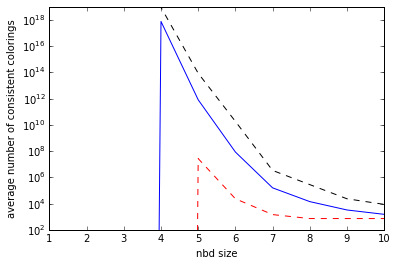

In [26]:
plt.plot(range(1,11), nc_mn)
plt.plot(range(1,11), nc_max, 'k--')
plt.plot(range(1,11), nc_min, 'r--')
plt.yscale('log')
plt.xlabel('nbd size')
plt.ylabel('average number of consistent colorings')


^^In the above, nbd size determines tree-width because each nbd. overlaps by all but 1 window.

In [24]:
##non-overlapping neighborhoods of fixed size
def nbds_generator_3(number_of_windows,num_nbds):
    nbds = []
    ends = np.linspace(0,number_of_windows,num=num_nbds+1,dtype=int,endpoint=True)
    print ends
    if len(ends) == 100000:
        nbds = [tuple(range(number_of_windows))]
    else:
        for ii,_ in enumerate(ends[:-1]):
            nbds += [tuple(range(ends[ii],ends[ii+1]))]
    return nbds

In [25]:
nbds_generator_3(64,8)

[ 0  8 16 24 32 40 48 56 64]


[(0, 1, 2, 3, 4, 5, 6, 7),
 (8, 9, 10, 11, 12, 13, 14, 15),
 (16, 17, 18, 19, 20, 21, 22, 23),
 (24, 25, 26, 27, 28, 29, 30, 31),
 (32, 33, 34, 35, 36, 37, 38, 39),
 (40, 41, 42, 43, 44, 45, 46, 47),
 (48, 49, 50, 51, 52, 53, 54, 55),
 (56, 57, 58, 59, 60, 61, 62, 63)]

In [27]:
n_colors = 6
n_windows = 8
n_samples = 500
target_sequence = range(n_windows)
nc_mn = []
nc_std = []
nc_min = []
nc_max = []
for n_nbds in reversed(range(1,n_windows,1)):
    ##construct the nbd
    nbds = uniquify(nbds_generator_3(n_windows,n_nbds))
    print '----number of nbds: %d' %(len(nbds))
    experimental_observations = dict((n,1) for n in nbds)
    exp_obs = format_experimental_obsevations(experimental_observations)
    ##construct the counting sequences
    seq = create_sequence_of_nbd_obs(target_sequence,exp_obs)
    sample_seq = make_color_count_sample_sequence(seq, n_colors, n_samples)
    counter_seq = []
    for s in seq:
        counter_seq.append(consistent_map_counter(s.target,s.nbd_windows.powerset(nonempty=True)))
    mess,mess_seq = indie_coloring_messenger(n_colors,seq,sample_seq,counter_seq,doprint=False)
    nc_mn.append(mess.mean())
    nc_std.append(mess.std())
    nc_min.append(mess.min())
    nc_max.append(mess.max())

[0 1 2 3 4 5 6 8]
----number of nbds: 7
===============target window: 0
===============target window: 1
===============target window: 2
===============target window: 3
===============target window: 4
===============target window: 5
===============target window: 6
===============target window: 7
[0 1 2 4 5 6 8]
----number of nbds: 6
===============target window: 0
===============target window: 1
===============target window: 2
===============target window: 3
===============target window: 4
===============target window: 5
===============target window: 6
===============target window: 7
[0 1 3 4 6 8]
----number of nbds: 5
===============target window: 0
===============target window: 1
===============target window: 2
===============target window: 3
===============target window: 4
===============target window: 5
===============target window: 6
===============target window: 7
[0 2 4 6 8]
----number of nbds: 4
===============target window: 0
===============target window: 1
===============targe

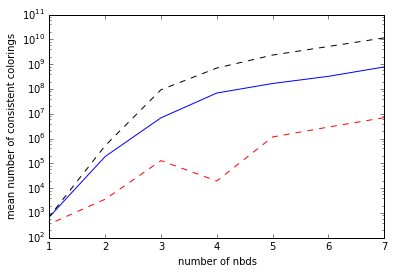

In [29]:
rng = list(reversed(range(1,n_windows,1)))
plt.plot(rng, nc_mn)
plt.plot(rng, nc_max, 'k--')
plt.plot(rng, nc_min, 'r--')
plt.yscale('log')
plt.xlabel('number of nbds')
plt.ylabel('mean number of consistent colorings')


^^Here the number of nbds is inversely proportional to number of windows per nbd. So with seven nbds
we have larger nbds than if we had only 1 nbd, for example. The total number of nbds is fixed (8) and so is the number of colors. This reinforces that idea that is tree-width that determines the number of consistent maps. The larger the tree-width, the less ambiguous things are.

### How many color-count samples are required stabilize the mean number of consistent colorings?

In [ ]:
n_colors = 6
n_windows = 16
nbd_size = 4
stride = 1
nbds = uniquify(nbds_generator_2(n_windows,nbd_size,stride))
print '----number of nbds: %d' %(len(nbds))
target_sequence = range(n_windows)

nc_mn = []
nc_std = []
nc_min = []
nc_max = []
##construct the counting sequences
for n_samples in np.logspace(0,4,num=5,dtype=int):
    print '------number of samples: %d' %(n_samples)
    experimental_observations = dict((n,1) for n in nbds)
    exp_obs = format_experimental_obsevations(experimental_observations)
    seq = create_sequence_of_nbd_obs(target_sequence,exp_obs)
    sample_seq = make_color_count_sample_sequence(seq, n_colors, n_samples)
    counter_seq = []
    for s in seq:
        counter_seq.append(consistent_map_counter(s.target,s.nbd_windows.powerset(nonempty=True)))
    mess,mess_seq = indie_coloring_messenger(n_colors,seq,sample_seq,counter_seq,doprint=False)
    nc_mn.append(mess.mean())
    nc_std.append(mess.std())
    nc_min.append(mess.min())
    nc_max.append(mess.max())

In [ ]:
rng =np.logspace(0,4,num=5,dtype=int)
plt.plot(rng, nc_mn)
plt.plot(rng, nc_max, 'k--')
plt.plot(rng, nc_min, 'r--')
plt.yscale('log')
plt.xlabel('number of samples')
plt.ylabel('mean number of consistent maps')
plt.show()

### A more efficient enumeration of colorings?

In [27]:
def enumerate_nbd_color_counts(n_colors, window_nbd, redundant=False):
    
    '''
    enumerate_nbd_color_counts(n_colors, window_nbd, redundant=False)
    window_nbd is a window object
    enumerates all possible color counts for the given window nbd
    returns a pandas dataframe, columns = window_nbd.powerset(nonempty=True).strings
    '''
    
    chunksize = 10000
    
    n_win = len(window_nbd.tup)
    windows = window_nbd
    window_names = windows.powerset(nonempty=True)
    unions = []
    cntr = 0
    start = time()

    coeffs = np.zeros((n_win,len(window_names.tups)))
    for ii,t in enumerate(window_names.tups):
        coeffs[t,ii] = 1

    
    for win_clrs in generate_window_colorings(n_colors,n_win,bits=False):
        if not np.mod(cntr,chunksize):
            cntr = 0
            print 'counts so far: %d' %(cntr)
            print 'takes %f seconds' %(time()-start)
            start = time()
 
            
        coloring_array = np.array(map(lambda x: np.fromstring(x,dtype='u1')-ord('0'),win_clrs))
        unions += [np.sum(coloring_array.T.dot(coeffs).clip(0,1),axis=0)]
        cntr += 1
    if redundant:
        return pd.DataFrame(np.array(unions), columns = window_names.strings)
    else:
        return pd.DataFrame(np.array(unions), columns = window_names.strings).drop_duplicates()

In [5]:
pdb

Automatic pdb calling has been turned ON


In [41]:
n_colors = 4
n_windows = 5
df = enumerate_nbd_color_counts(n_colors,window(range(n_windows)),redundant=False)

counts so far: 0
takes 0.000270 seconds
counts so far: 0
takes 0.388359 seconds
counts so far: 0
takes 0.388082 seconds
counts so far: 0
takes 0.388786 seconds
counts so far: 0
takes 0.387274 seconds
counts so far: 0
takes 0.389195 seconds
counts so far: 0
takes 0.394471 seconds
counts so far: 0
takes 0.396599 seconds
counts so far: 0
takes 0.394825 seconds
counts so far: 0
takes 0.389866 seconds
counts so far: 0
takes 0.389050 seconds
counts so far: 0
takes 0.391229 seconds
counts so far: 0
takes 0.388920 seconds
counts so far: 0
takes 0.393976 seconds
counts so far: 0
takes 0.390305 seconds
counts so far: 0
takes 0.392008 seconds
counts so far: 0
takes 0.394024 seconds
counts so far: 0
takes 0.390486 seconds
counts so far: 0
takes 0.391224 seconds
counts so far: 0
takes 0.391195 seconds
counts so far: 0
takes 0.392304 seconds
counts so far: 0
takes 0.392345 seconds
counts so far: 0
takes 0.389499 seconds
counts so far: 0
takes 0.390393 seconds
counts so far: 0
takes 0.390086 seconds


KeyboardInterrupt: 

> <ipython-input-27-51f22ae90d02>(26)enumerate_nbd_color_counts()
     25         coloring_array = np.array(map(lambda x: np.fromstring(x,dtype='u1')-ord('0'),win_clrs))
---> 26         unions += [np.sum(coloring_array.T.dot(coeffs).clip(0,1),axis=0)]
     27         cntr += 1

ipdb> q


In [39]:
df.shape

(2923, 31)

This approach requires $(2^n-1)^t$ enumerations, where n=number of color, and t=number of windows.
But the number of possible color counts is only:

In [40]:
n_color_counts = df.shape[0]
n_colorings = (2**n_colors-1)**n_windows
print 'number of possible color counts: %d' %(n_color_counts)
print 'compared to the number of colorings: %d' %(n_colorings)
print 'for a reduction to %f percent of the total number of colorings' %(n_color_counts / float(n_colorings)*100)

number of possible color counts: 2923
compared to the number of colorings: 16807
for a reduction to 17.391563 percent of the total number of colorings


So, we should really not be enumerating all of the colorings. In my notebook I worked out a formula for the number of colorings that factors into two components: histograms and samples. I think that just the number of histograms will equal the number of possible colorings. It goes like this:

In [ ]:
def partition(number):
...     answer = set()
...     answer.add((number, ))
...     for x in range(1, number):
...         for y in partition(number - x):
...             answer.add(tuple(sorted((x, ) + y)))
...     return answer

In [ ]:
def descending_combo(upper, lower):
    counter = 0
    mult = 1
    for low in lower:
#         print '%d,%d' %(n_colorings-counter, h)
        mult *= comb(upper-counter,low,exact='True')
        counter += low
    return mult

In [ ]:
n = n_colors  #number of colors
t = n_windows #number of windows
n_assignments = 2**t-1 # number of ways to assign one color to t windows
parts = partition(n)
parts = [p for p in parts if len(p) <= n_assignments]
count = 0
histo_count = 0
for p in parts:
#     print 'partition: %s' %((p,))
    _,h_counts = np.unique(p,return_counts=True)   ##h_counts = histogram of bar heights
    n_histo = descending_combo(n_assignments,h_counts)
    n_samples = descending_combo(n,p)
#     print n_histo
#     print n_samples
    histo_count += n_histo
    count += n_histo*n_samples
# print '===='

print count-n_assignments**n

In [ ]:
n_assignments**n

In [ ]:
histo_count

In [ ]:
sample_count